In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr
import pyret

In [5]:
optimum_para = {}
optimum_para['gaussian'] = [0.61, 0.56, 0.56, 0.66, 1., 0.94]
optimum_para['poisson1'] = [5.56, 8.87, 4.65, 4.75, 1., 1.49]
optimum_para['poisson2'] = [3.81, 5.03, 3.30, 3.11, 6.10, 0.82]
optimum_para['binomial'] = [2.17, 2.85, 1.91, 2.14, 1., 0.64]

t_list = [3,3,3,4,2,4]

In [8]:
lls = {'gaussian':[], 'poisson1':[], 'poisson2':[], 'binomial':[]}
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
recording = recording_stats(file_path, cells)
for cell in range(6):
    dist = distribution(t_list[cell])
    
    ll = dist.log_likelihood('truncated_gaussian', optimum_para['gaussian'][cell], recording.single_trial_bin, cell)
    lls['gaussian'].append(ll)
    
    ll = dist.log_likelihood('truncated_poisson', optimum_para['poisson1'][cell], recording.single_trial_bin, cell, p_version=1)
    lls['poisson1'].append(ll)
    
    ll = dist.log_likelihood('truncated_poisson', optimum_para['poisson2'][cell], recording.single_trial_bin, cell, p_version=2)
    lls['poisson2'].append(ll)
    
    ll = dist.log_likelihood('binomial_scale', optimum_para['binomial'][cell], recording.single_trial_bin, cell)
    lls['binomial'].append(ll)

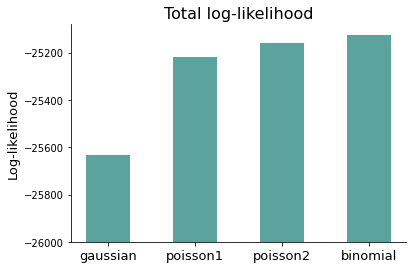

In [30]:
fig, ax = plt.subplots()
bottom = 26000
labels = lls.keys()
x = np.arange(len(labels))
y = np.array([sum(lls[key]) for key in lls.keys()]) + bottom
rect = ax.bar(x, y, color='#5DA39D', width=0.5, bottom = -bottom)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=13)
ax.set_ylabel('Log-likelihood', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Total log-likelihood', fontsize=16)
plt.show()

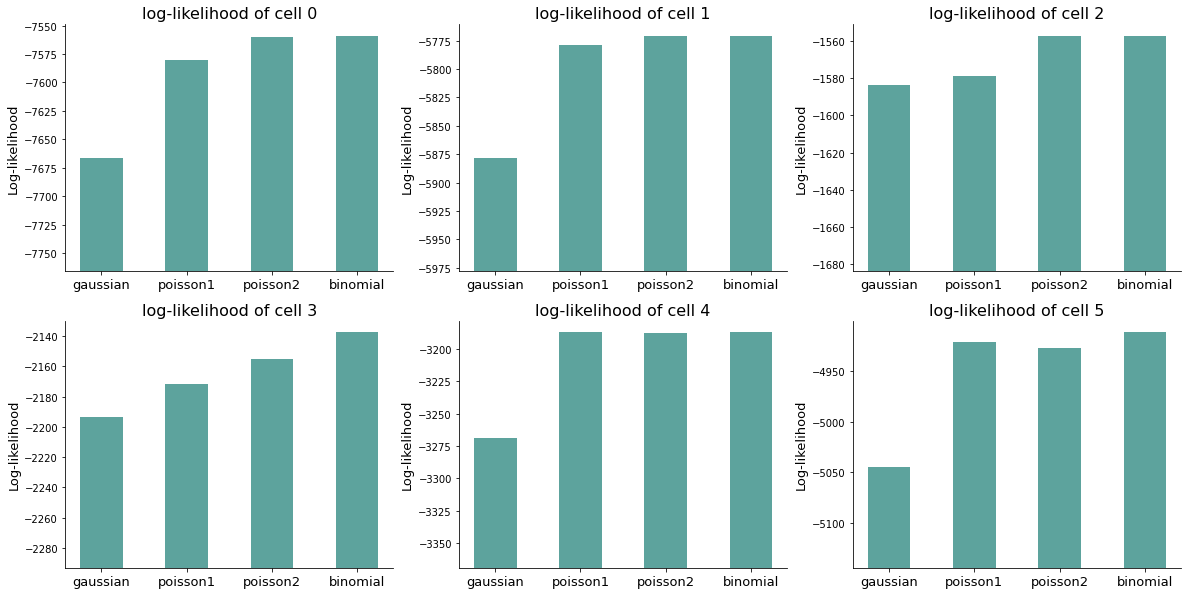

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(6):
    bottom = - min([lls[key][i] for key in lls.keys()]) + 100
    labels = lls.keys()
    x = np.arange(len(labels))
    y = np.array([lls[key][i] for key in lls.keys()]) + bottom
    rect = ax[i//3, i%3].bar(x, y, color='#5DA39D', width=0.5, bottom = -bottom)
    ax[i//3, i%3].set_xticks(x)
    ax[i//3, i%3].set_xticklabels(labels, fontsize=13)
    ax[i//3, i%3].set_ylabel('Log-likelihood', fontsize=13)
    ax[i//3, i%3].spines['right'].set_visible(False)
    ax[i//3, i%3].spines['top'].set_visible(False)
    ax[i//3, i%3].set_title('log-likelihood of cell {}'.format(i), fontsize=16)
plt.show()

In [25]:
kls = {'gaussian':[], 'poisson1':[], 'poisson2':[], 'binomial':[]}
for cell in range(6):
    dist = distribution(t_list[cell])
    
    kl = dist.KL('truncated_gaussian', optimum_para['gaussian'][cell], recording, cell)
    kls['gaussian'].append(kl)
    
    kl = dist.KL('truncated_poisson', optimum_para['poisson1'][cell], recording, cell, p_version=1)
    kls['poisson1'].append(kl)
    
    kl = dist.KL('truncated_poisson', optimum_para['poisson2'][cell], recording, cell, p_version=2)
    kls['poisson2'].append(kl)
    
    kl = dist.KL('binomial_scale', optimum_para['binomial'][cell], recording, cell)
    kls['binomial'].append(kl)

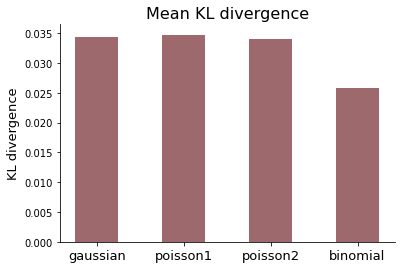

In [32]:
fig, ax = plt.subplots()
labels = kls.keys()
x = np.arange(len(labels))
y = np.array([sum(kls[key])/6 for key in kls.keys()])
rect = ax.bar(x, y, color='#9E696D', width=0.5)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=13)
ax.set_ylabel('KL divergence', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Mean KL divergence', fontsize=16)
plt.show()

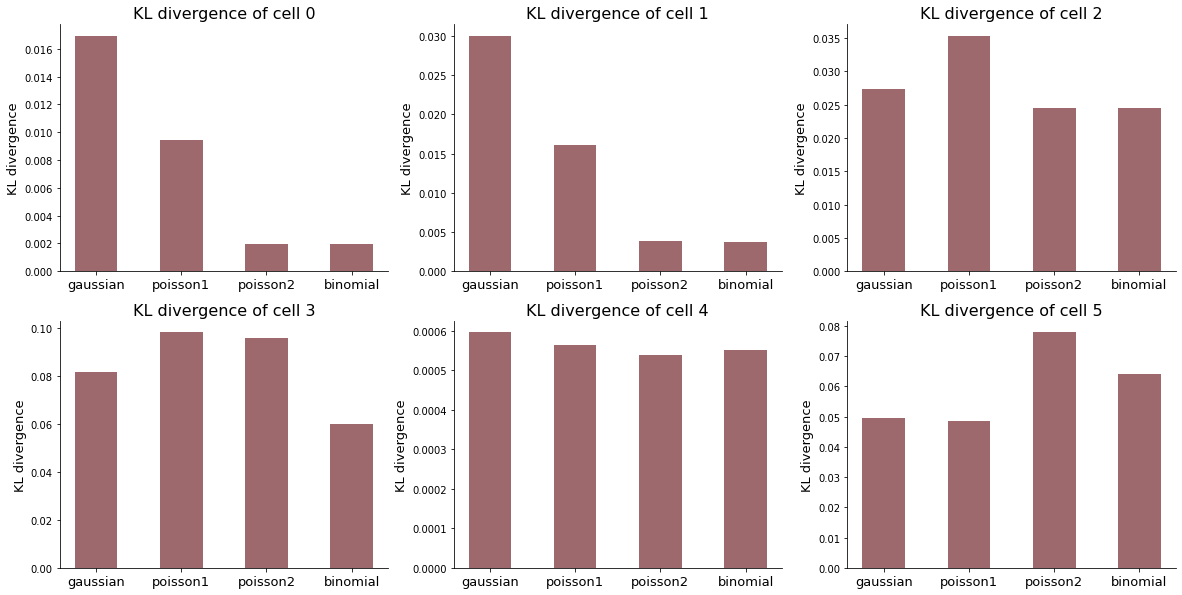

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range(6):
    labels = kls.keys()
    x = np.arange(len(labels))
    y = np.array([kls[key][i] for key in kls.keys()])
    rect = ax[i//3, i%3].bar(x, y, color='#9E696D', width=0.5)
    ax[i//3, i%3].set_xticks(x)
    ax[i//3, i%3].set_xticklabels(labels, fontsize=13)
    ax[i//3, i%3].set_ylabel('KL divergence', fontsize=13)
    ax[i//3, i%3].spines['right'].set_visible(False)
    ax[i//3, i%3].spines['top'].set_visible(False)
    ax[i//3, i%3].set_title('KL divergence of cell {}'.format(i), fontsize=16)
plt.show()

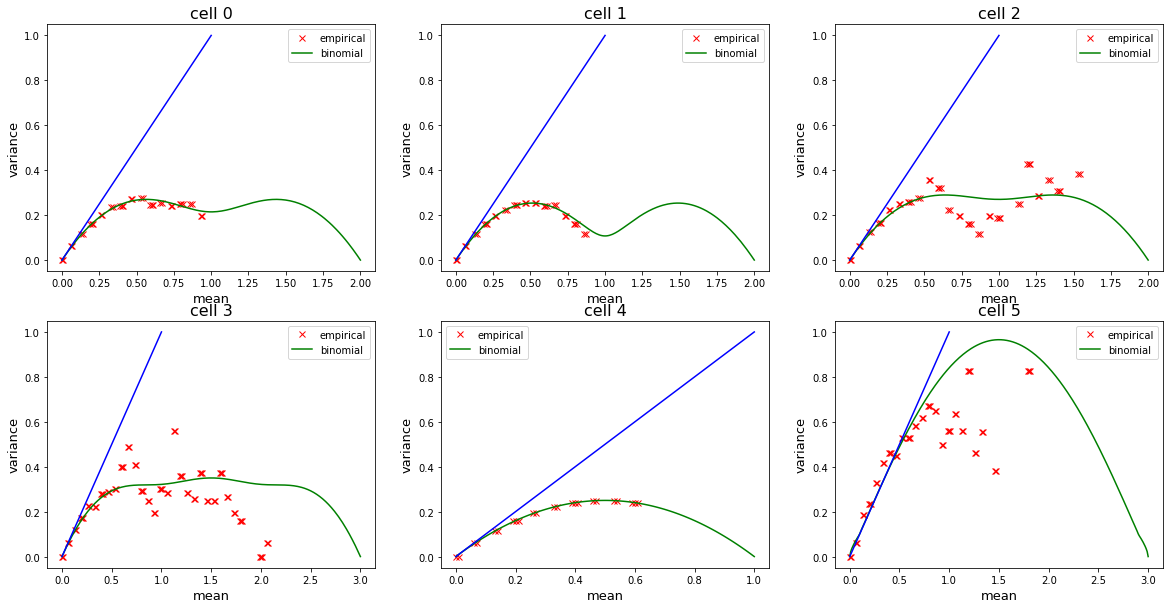

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for cell in range(6):
    dist = distribution(t_list[cell])
    means = []
    means_dis = []
    variances = []
    vars_dis = []
    for rate in range(100*t_list[cell]):
        mean, var, em = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
        if not np.isnan(mean):
            means.append(rate/100)
            variances.append(var)
        try:
            r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
            var = dist.var('binomial_scale', r, optimum_para['binomial'][cell])
            means_dis.append(rate/100)
            vars_dis.append(var)
        except:
            pass
    ax[cell//3, cell%3].plot(means, variances, 'rx', label='empirical')
    ax[cell//3, cell%3].plot(means_dis, vars_dis, 'g-', label='binomial')
    ax[cell//3, cell%3].plot([0, 1], [0, 1], 'b')
    ax[cell//3, cell%3].legend()
    ax[cell//3, cell%3].set_xlabel('mean', fontsize=13)
    ax[cell//3, cell%3].set_ylabel('variance', fontsize=13)
    ax[cell//3, cell%3].set_title('cell {}'.format(cell), fontsize=16)
plt.show()

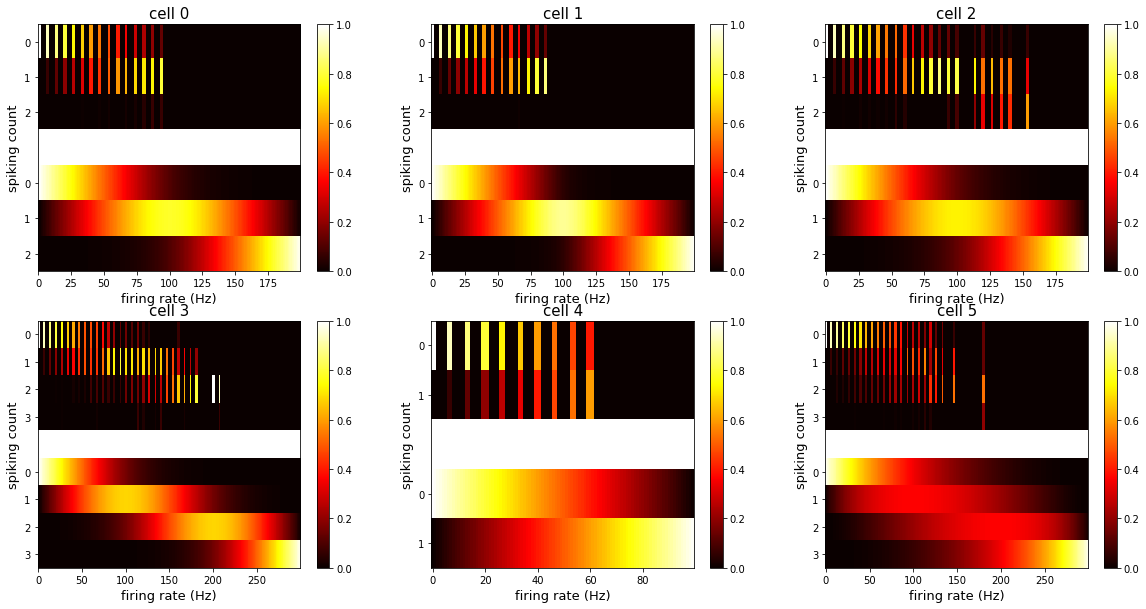

In [130]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for cell in range(6):
    dist = distribution(t_list[cell])
    ems = []
    ps = []
    means = []
    for rate in range(100*t_list[cell]):
        means.append(rate/100)
        mean, _, em = recording.stats_rate(100*recording.single_trial_bin.mean(0), cell, rate)
        if not np.isnan(mean):
            ems.append(em[:t_list[cell]])
        else:
            ems.append(np.zeros((t_list[cell])))
        try:
            r = dist.rate2para('binomial_scale', optimum_para['binomial'][cell], rate)
            p = np.array([dist.binomial_scale(i, r, optimum_para['binomial'][cell]) for i in range(t_list[cell])])
            ps.append(p)
        except:
            ps.append(np.zeros((t_list[cell])))
    ems = np.array(ems)
    ps = np.array(ps)
    means = np.array(means)
    
    max_index = max(np.where(ems!=0)[0].max(), np.where(ps!=0)[0].max())
    ems = ems[:max_index]
    ps = ps[:max_index]
    means = means[:max_index]
    full = np.concatenate((ems, np.ones((max_index, 1)), ps), axis=1)

    p = ax[cell//3, cell%3].imshow(full.T, aspect='auto', cmap='hot', interpolation='none')
    ax[cell//3, cell%3].set_yticks(list(range(t_list[cell]))+list(range(t_list[cell]+1, 2*t_list[cell]+1)))
    ax[cell//3, cell%3].set_xlabel('firing rate (Hz)', fontsize=13)
    ax[cell//3, cell%3].set_yticklabels(list(range(t_list[cell]))+list(range(t_list[cell])))
    ax[cell//3, cell%3].set_ylabel('spiking count', fontsize=13)
    ax[cell//3, cell%3].set_title('cell {}'.format(cell), fontsize=15)
    fig.colorbar(p, ax=ax[cell//3, cell%3])
plt.show()